In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)


In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [19]:
matplotlib.rcParams['figure.figsize'] = [20, 6]

In [3]:
import settings
from helpers import osu
import libtempo_py as lt

In [4]:
osu_root = os.getenv('OSU_ROOT')

In [5]:
import numpy as np
import pandas as pd
import librosa.display

In [6]:
dataset = pd.read_csv("../data/dataset_entries.csv", dtype=dict(avg_bpm=np.float64, time_total=np.int32))

In [31]:
sample = dataset.sample().iloc[0]
sample_path = f'{osu_root}\\Songs\\{sample.folder_name}'
print(sample_path)
print(sample)

F:\Osu\Songs\410935 KAKAO FRIENDS - APEACH SPECIAL
Unnamed: 0                                                  1080
title                                             APEACH SPECIAL
artist                                             KAKAO FRIENDS
creator                                                    Natsu
folder_name                410935 KAKAO FRIENDS - APEACH SPECIAL
audio_file                                               gfg.mp3
osu_file       KAKAO FRIENDS - APEACH SPECIAL (Natsu) [Apeach...
beatmap_id                                                891651
set_id                                                    410935
time_total                                                 66011
avg_bpm                                                  118.046
bpm_class                                                      9
Name: 1080, dtype: object


# Process a sample

In [32]:
# Load beatmap
beatmap_path = f'{sample_path}\\{sample.osu_file}'
beatmap = osu.beatmap_reader.read(beatmap_path)
beatmap.title

'APEACH SPECIAL'

In [33]:
# Read existing timing points
timingpoints = list(filter(lambda x: isinstance(x, osu.models.KeyTimingPoint), beatmap.timingpoints))
for t in timingpoints: print(f'Time: {t.offset/1000}, BPM: {60000 / t.mpb}')

Time: 0.0, BPM: 119.74999999999999
Time: 7.014, BPM: 109.9999999999999
Time: 8.104, BPM: 114.99999999999991
Time: 9.147, BPM: 119.74999999999999
Time: 13.403, BPM: 119.74999999999999
Time: 45.845, BPM: 119.74999999999999
Time: 53.36, BPM: 119.74999999999999
Time: 56.867, BPM: 119.74999999999999
Time: 65.51, BPM: 119.74999999999999


In [34]:
# Read audio file
audio_path = f'{sample_path}\\{sample.audio_file}'
audio = lt.audio.AudioWrapper(audio_path)
audio_mono = lt.wrap_arrayF(np.mean(audio.get_data().to_array(), axis=0))
print(f'Loaded audio. Duration {audio_mono.get_shape()[0]/audio.get_sr()}')

Loaded audio. Duration 70.47836734693878


In [35]:
# Novelty curve
novelty_curve, novelty_curve_sr = lt.audio_to_novelty_curve(audio_mono, audio.get_sr())

In [36]:
# Tempogram
start_tempo = 30
end_tempo = 630
tempogram_y_axis = lt.wrap_arrayD(np.arange(start_tempo, end_tempo))
tempogram, tempogram_y_axis, t = lt.novelty_curve_to_tempogram(novelty_curve, tempogram_y_axis, novelty_curve_sr, 8)
tempogram.get_shape()

(600, 353)

In [37]:
t_np = t.to_array()[:, 0]

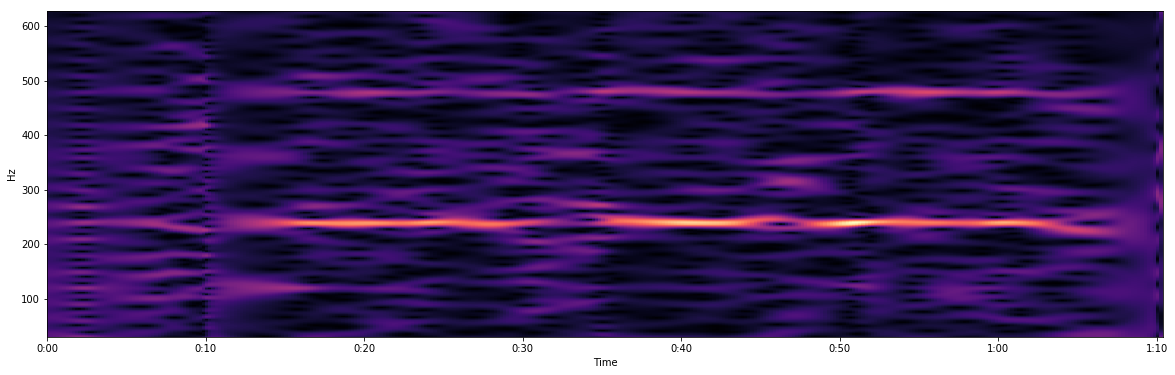

In [38]:
# Show tempogram
librosa.display.specshow(np.abs(tempogram.to_array()), x_axis='time', y_axis='linear', x_coords=t_np, y_coords=tempogram_y_axis.to_array()[:, 0])

In [39]:
# Cyclic tempogram
ref_tempo = 60
cyclic_tempogram, cyclic_tempogram_y_axis = lt.tempogram_to_cyclic_tempogram(tempogram, tempogram_y_axis, ref_tempo=ref_tempo)
cyclic_tempogram.get_shape()

(120, 353)

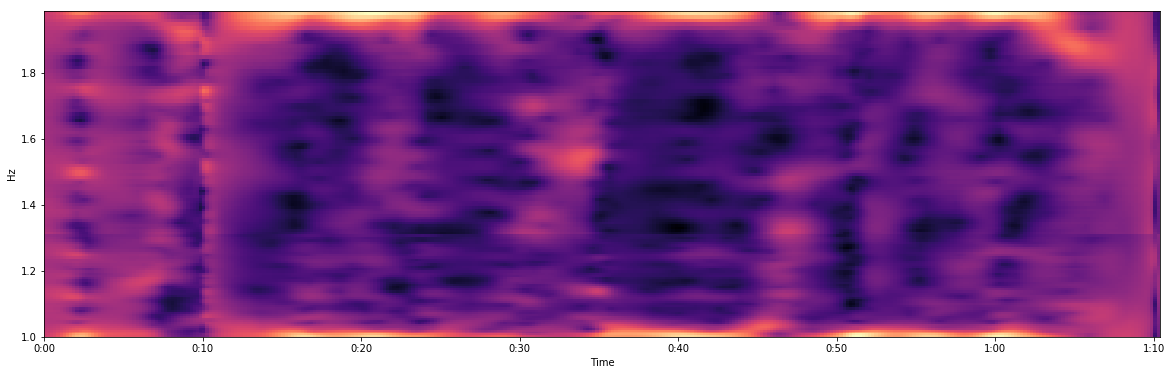

In [40]:
# Show cyclic tempogram
librosa.display.specshow(np.abs(cyclic_tempogram.to_array()), x_axis='time', y_axis='linear', x_coords=t_np, y_coords=cyclic_tempogram_y_axis.to_array()[:, 0])

In [41]:
# Smoothen tempogram
smooth_length = 20
smoothed_tempogram = lt.smoothen_tempogram(cyclic_tempogram, cyclic_tempogram_y_axis, t, smooth_length)

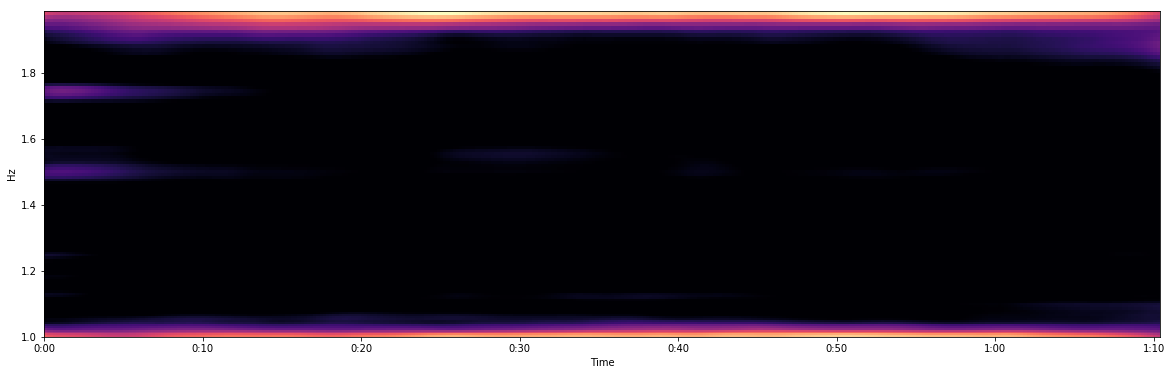

In [42]:
# Show smoothed tempogram
librosa.display.specshow(np.abs(smoothed_tempogram.to_array()), x_axis='time', y_axis='linear', x_coords=t_np, y_coords=cyclic_tempogram_y_axis.to_array()[:, 0])

In [57]:
# Tempo sections
tempo_curve = lt.tempogram_to_tempo_curve(smoothed_tempogram, cyclic_tempogram_y_axis)
tempo_curve = lt.correct_tempo_curve(tempo_curve, t, 5)
tempo_sections = lt.curve_to_sections(tempo_curve, t, ref_tempo, 100000, 1.5)
for s in tempo_sections: print(f'Time: {s.start}, BPM: {s.bpm}')

Time: 0.0, BPM: 119.30885085810566


# Test a dataset item

In [44]:
candidate_section = tempo_sections[0]

In [45]:
section_start_idx = np.searchsorted(t_np, candidate_section.start)
section_end_idx = np.searchsorted(t_np, candidate_section.end)
print(f'{section_start_idx} to {section_end_idx}')

0 to 352


In [46]:
tempogram_np = np.abs(tempogram.to_array())

In [47]:
tempo_distribution = np.sum(tempogram_np[:, section_start_idx:section_end_idx], axis=1)
tempo_distribution -= np.mean(tempo_distribution)
tempo_distribution[tempo_distribution < 0] = 0
tempo_distribution.shape

(600,)

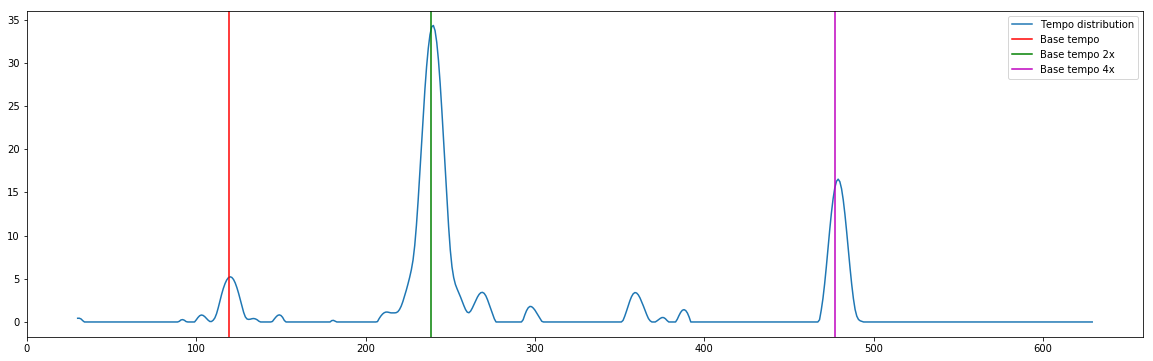

In [49]:
plt.plot(np.arange(start_tempo, end_tempo), tempo_distribution, label='Tempo distribution')
plt.axvline(x=candidate_section.bpm, label='Base tempo', color='r')
plt.axvline(x=candidate_section.bpm * 2, label='Base tempo 2x', color='g')
plt.axvline(x=candidate_section.bpm * 4, label='Base tempo 4x', color='m')
if candidate_section.bpm * 8 < end_tempo:
    plt.axvline(x=candidate_section.bpm * 8, label='Base tempo 8x', color='m')
plt.legend()

# Generate better labels

In [69]:
class Section:
    __slots__ = 'start', 'end', 'bpm', 'offset'
    
    def __init__(self, start, end, bpm, offset):
        self.start = start
        self.end = end
        self.bpm = bpm
        self.offset = offset

def merge_sections(s1, s2):
    return Section(min(s1.start, s2.start), max(s1.end, s2.end), np.mean([s1.bpm, s2.bpm]), np.mean([s1.offset, s2.offset]))

In [58]:
label_sections = []
for i in range(len(timingpoints)):
    end = timingpoints[i+1].offset if i+1 < len(timingpoints) else tempo_sections[-1].end
    tp = timingpoints[i]
    s = Section(abs(tp.offset) / 1000, end, 60000/tp.mpb, tp.offset / 1000)
    label_sections.append(s)

for s in label_sections: print(f'Time: {s.start}, BPM: {s.bpm}')

Time: 0.0, BPM: 119.74999999999999
Time: 7.014, BPM: 109.9999999999999
Time: 8.104, BPM: 114.99999999999991
Time: 9.147, BPM: 119.74999999999999
Time: 13.403, BPM: 119.74999999999999
Time: 45.845, BPM: 119.74999999999999
Time: 53.36, BPM: 119.74999999999999
Time: 56.867, BPM: 119.74999999999999
Time: 65.51, BPM: 119.74999999999999


In [71]:
merge_threshold = 10
label_sections_cleaned = [label_sections[0]]

for s in label_sections[1:]:
    if(abs(label_sections_cleaned[-1].bpm - s.bpm) < merge_threshold):
        label_sections_cleaned[-1] = merge_sections(label_sections_cleaned[-1], s)
    else: label_sections_cleaned.append(s)

for s in label_sections_cleaned: print(f'Time: {s.start}, BPM: {s.bpm}')

Time: 0.0, BPM: 119.6745098084211


## Pick multiples for generated sections

In [61]:
def find_truth_section(t):
    for s in label_sections_cleaned:
        if t >= s.start and t < s.end: return s
    return label_sections_cleaned[-1]

In [62]:
def slice_section(s, t):
    s1 = Section(s.start, t, s.bpm, s.offset)
    s2 = Section(t, s.end, s.bpm, s.offset)
    return s1, s2

In [66]:
section_multiples = []
candidates = list(reversed(tempo_sections))

while len(candidates) > 0:
    s = candidates.pop()
    st = find_truth_section(s.start)
    if s.end > st.end:
        s, sn = slice_section(s, st.end)
        candidates.append(sn)
    
    section_multiples.append((s, int(np.round(st.bpm / s.bpm))))

for s, m in section_multiples: print(f'Time: {s.start}, BPM: {s.bpm}, Multiple: {m}')

Time: 0.0, BPM: 119.30885085810566, Multiple: 1


In [72]:
duration_threshold = 5
bpm_threshold = 4
section_multiples_cleaned_tmp = list(filter(lambda sm: (sm[0].end - sm[0].start) > duration_threshold, section_multiples))
section_multiples_cleaned = [section_multiples_cleaned_tmp[0]]

for s, m in section_multiples_cleaned_tmp[1:]:
    prev_s, prev_m = section_multiples_cleaned[-1]
    if prev_m == m and abs(prev_s.bpm - s.bpm) < bpm_threshold:
        section_multiples_cleaned[-1] = (merge_sections(prev_s, s), m)
    else: section_multiples_cleaned.append((s, m))

for s, m in section_multiples_cleaned: print(f'Time: {s.start}, BPM: {s.bpm}, Multiple: {m}')

Time: 0.0, BPM: 119.30885085810566, Multiple: 1
